In [207]:
haiend_to_hai = {
    # Setpoint (pressure demand)
    "1001.15-OUT": "P1_B2016",

    # Flow control valves (command & feedback)
    "DM-FCV01-D": "P1_FCV01D",
    "DM-FCV01-Z": "P1_FCV01Z",
    "DM-FCV02-D": "P1_FCV02D",
    "DM-FCV02-Z": "P1_FCV02Z",
    "DM-FCV03-D": "P1_FCV03D",
    "DM-FCV03-Z": "P1_FCV03Z",

    # Flow transmitters (raw & converted)
    "DM-FT01":  "P1_FT01",
    "DM-FT01Z": "P1_FT01Z",
    "DM-FT02":  "P1_FT02",
    "DM-FT02Z": "P1_FT02Z",
    "DM-FT03":  "P1_FT03",
    "DM-FT03Z": "P1_FT03Z",

    # Level control valve & level indicator
    "DM-LCV01-D": "P1_LCV01D",
    "DM-LCV01-Z": "P1_LCV01Z",
    "DM-LIT01":   "P1_LIT01",

    # Pressure control valves
    "DM-PCV01-D": "P1_PCV01D",
    "DM-PCV01-Z": "P1_PCV01Z",
    "DM-PCV02-D": "P1_PCV02D",
    "DM-PCV02-Z": "P1_PCV02Z",

    # Pressure indicators (incl. high-high)
    "DM-PIT01-HH": "P1_PIT01_HH",
    "DM-PIT01":    "P1_PIT01",
    "DM-PIT02":    "P1_PIT02",

    # Pumps (commands & running states)
    "DM-PP01A-D": "P1_PP01AD",
    "DM-PP01A-R": "P1_PP01AR",
    "DM-PP01B-D": "P1_PP01BD",
    "DM-PP01B-R": "P1_PP01BR",
    "DM-PP02-D":  "P1_PP02D",
    "DM-PP02-R":  "P1_PP02R",

    # Solenoids & start/stop flag
    "DM-SOL01-D": "P1_SOL01D",
    "DM-SOL03-D": "P1_SOL03D",
    "DM-ST-SP":   "P1_STSP",

    # Temperatures (note: TIT02→TIT03 per doc)
    "DM-TIT01": "P1_TIT01",
    "DM-TIT02": "P1_TIT03",

    # Turbine governor opening
    "GATEOPEN": "P4_ST_GOV",
}

In [208]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# Loading coloumn names
df1 = pd.read_csv('../hai-21.03/train1.csv', nrows=1)
df2 = pd.read_csv('../hai-22.04/train2.csv', nrows=1)
df3 = pd.read_csv('../haiend-23.05/end-train3.csv', nrows=1)

df3.rename(columns=haiend_to_hai, inplace=True)
# Get sets of column names
cols1 = set(df1.columns)
cols2 = set(df2.columns)
cols3 = set(df3.columns)

# Find common columns across all three datasets
common_cols = cols1 & cols2 & cols3

print(len(common_cols))

31


From the table of tag descriptions (pages 12–15 in hai_dataset_technical_details.pdf):

“Each control valve is represented by a pair of data points, one with the suffix D (desired position) and one with the suffix Z (current position).
The ‘D’ variable is the actuator command signal issued by the controller;
the ‘Z’ variable is the feedback signal from the valve’s position sensor.”

In [209]:
sensors_21_23 = ['P1_LIT01','P1_TIT01','P1_TIT02','P1_PIT01','P1_PIT02','P1_FT01', 'P1_FT01Z','P1_FT02', 'P1_FT02Z','P1_FT03', 'P1_FT03Z']
# sensor-21-22 = [col for col in common_cols if any(x in col for x in [
#     'P1_TIT01', 'P1_TIT02',
#     'P1_PIT01', 'P1_PIT02',
#     'P1_LIT01',
#     'P1_FT01', 'P1_FT02', 'P1_FT03',
#     'P3_FIT01', 'P3_LIT01', 'P3_PIT01',
#     'P2_SIT01', 'P2_VT01',
#     'P4_HT_FD', 'P4_HT_PO', 'P4_HT_PS',
#     'P4_ST_FD', 'P4_ST_PO', 'P4_ST_PS',
#     'P4_ST_TT01', 'P4_ST_PT01', 'P4_ST_LD', 'P4_LD'
# ])]
sensor_21_22 = [ 
    'P1_TIT01', 'P1_TIT02',
    'P1_PIT01', 'P1_PIT02',
    'P1_LIT01',
    'P1_FT01', 'P1_FT02', 'P1_FT03',
    'P3_FIT01', 'P3_LIT01', 'P3_PIT01',
    'P2_SIT01', 'P2_VT01',
    'P4_HT_FD', 'P4_HT_PO', 'P4_HT_PS',
    'P4_ST_FD', 'P4_ST_PO', 'P4_ST_PS',
    'P4_ST_TT01', 'P4_ST_PT01', 'P4_ST_LD', 'P4_LD'
]
#'P2_VTR01', 'P2_VTR02', 'P2_VTR03', 'P2_VTR04' vibration sensors
# “Some of the turbine vibration and speed-related channels were included for completeness,but in the current simulation scenario these values were fixed due to the absence of real vibration modeling.”  should exclude because of constant value as it will result in D=0


print(f"Sensors 21-22: {len(sensor_21_22)}")
print(f"Sensors 21-23: {len(sensors_21_23)}")

Sensors 21-22: 23
Sensors 21-23: 11


In [210]:

hai_21_files = sorted(glob("../hai-21.03/train*.csv")) + sorted(glob("../hai-21.03/test*.csv"))
hai_22_files = sorted(glob("../hai-22.04/train*.csv")) + sorted(glob("../hai-22.04/test*.csv"))
hai_23_files = sorted(glob("../hai-23.05/hai-train*.csv")) + sorted(glob("../hai-23.05/hai-test*.csv"))

hai_21_attack_cols = ['attack', 'attack_P1', 'attack_P2', 'attack_P3']

In [211]:

def load_data(files):
    """Load data, remove attack samples, and clean NaN values"""
    # Load sensor and attack columns
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)        
    
    # Forward fill to handle any remaining NaN values
    #df = df.fillna(method='ffill')
    
    return df

def remove_attack_samples(df, attack_cols):
    """Remove attack samples from the dataframe"""
    # Check if attack columns exist in dataframe
    missing_cols = [col for col in attack_cols if col not in df.columns]
    if missing_cols:
        # If none of the attack columns exist, just return df
        return df
    # Remove attack samples (keep only rows where all attack columns are 0)
    df = df[(df[attack_cols] == 0).all(axis=1)]
    
    # Drop attack columns after filtering
    df = df.drop(columns=attack_cols)
    
    return df

def z_score_normalize(df):
    """Z-score normalization (standardization)"""
    return (df - df.mean()) / df.std()


def empirical_cdf(sample):
    sorted_x = np.sort(sample)
    y = np.arange(1, len(sorted_x)+1) / len(sorted_x)
    return sorted_x, y

def ks_statistic(sample1, sample2):
    if len(sample1) == 0 or len(sample2) == 0:
        return np.nan
    x1, F1 = empirical_cdf(sample1)
    x2, F2 = empirical_cdf(sample2)
    all_x = np.sort(np.unique(np.concatenate([x1, x2])))
    F1_all = np.searchsorted(x1, all_x, side="right") / len(x1)
    F2_all = np.searchsorted(x2, all_x, side="right") / len(x2)
    D = np.max(np.abs(F1_all - F2_all))
    return D

def compare_datasets(dfA, dfB):
    ks_values = {}
    for col in dfA.columns:
        D = ks_statistic(dfA[col], dfB[col])
        ks_values[col] = D
    return ks_values

In [212]:
df21 = load_data(hai_21_files)
df22 = load_data(hai_22_files)
df23 = load_data(hai_23_files)


For adding attack samples to data

In [213]:
# Merge label files and add attack column, 
label_files = ["../haiend-23.05/label-test1.csv", "../haiend-23.05/label-test2.csv"]
label_df = pd.concat([pd.read_csv(f) for f in label_files], ignore_index=True)


# Merge labels into test data and create attack column
df23 = (
    pd.merge(df23, label_df, on='timestamp', how='left')
    .assign(attack=lambda x: x['label'].fillna(0).astype(int))
    .drop(columns=['label'])
)

Attack samples are removed from dfs

In [214]:
df21 = remove_attack_samples(df21, hai_21_attack_cols)
df22 = remove_attack_samples(df22, ['Attack'])
df23 = remove_attack_samples(df23, ['attack'])

In [ ]:

df21_sensor = df21[sensors_21_23]
df22_sensor = df22[sensors_21_23]
df23_sensor = df23[sensors_21_23]

#mean and std
# print(df21_sensor.P2_VTR02.mean(), df21_sensor.P2_VTR02.std(), df21_sensor.P2_VTR02.min(), df21_sensor.P2_VTR02.max())
df21_normalized = z_score_normalize(df21_sensor)
df22_normalized = z_score_normalize(df22_sensor)
df23_normalized = z_score_normalize(df23_sensor)



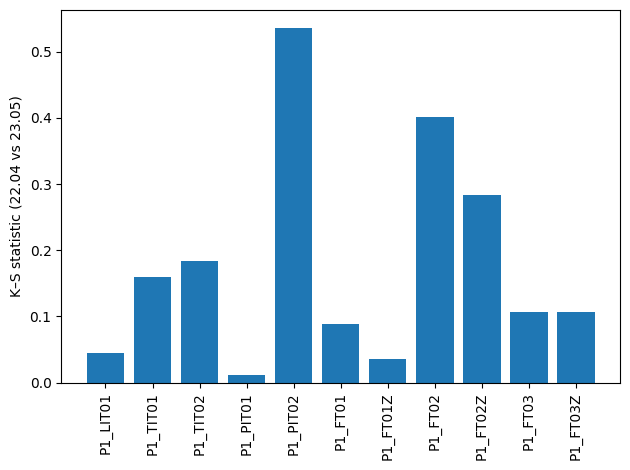

In [ ]:
ks_21_22 = compare_datasets(df21_normalized, df22_normalized)
ks_22_23 = compare_datasets(df22_normalized, df23_normalized)

# # Plot ECDFs for P1_FT01 and P1_FT01Z
# x1, F1 = empirical_cdf(df21_normalized['P2_VTR02'])
# x2, F2 = empirical_cdf(df22_normalized['P2_VTR02'])
# plt.step(x1, F1, label='P1_TIT02')
# plt.step(x2, F2, label='P1_TIT02')
# plt.xlabel('Value')
# plt.ylabel('ECDF')
# plt.title('ECDF Comparison')
# plt.legend()
# plt.show()

# plot histograms for reference
# plt.hist(df21_normalized['P1_FT01'], bins=50, alpha=0.5, label='P1_FT01')
# plt.hist(df21_normalized['P1_FT01Z'], bins=50, alpha=0.5, label='P1_FT01Z')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram Comparison')
# plt.legend()
# plt.show()

# Bar plot for KS statistics
plt.bar(range(len(ks_22_23)), list(ks_22_23.values()))
plt.xticks(range(len(ks_22_23)), list(ks_22_23.keys()), rotation=90)
plt.ylabel("K–S statistic (22.04 vs 23.05)")
plt.tight_layout()
plt.show()

Task 2b  (actuator)

Here attack samples are already removed from df

actuators = [col for col in common_cols if any(x in col for x in [
# Pumps / Solenoids / Start-stop
     'P1_PCV01D', 'P1_PCV02D',
    'P1_FCV01D', 'P1_FCV02D', 'P1_FCV03D',
    'P1_LCV01D',
    'P1_PP01AD', 'P1_PP01BD', 'P1_PP02D',
    'P2_ManualGO', 'P2_OnOff', 'P2_Emerg', 'P2_TripEx',
    'P3_LCV01D', 'P3_LCP01D',
    'P2_Emerg','P2_TripEx','P2_RTR'
])]

# actuators = [
#     # --- Flow / Level / Pressure Control Valves ---
#     'P1_FCV01D', 'P1_FCV01Z',
#     'P1_FCV02D', 'P1_FCV02Z',
#     'P1_FCV03D', 'P1_FCV03Z',
#     'P1_LCV01D', 'P1_LCV01Z',
#     'P1_PCV01D', 'P1_PCV01Z',
#     'P1_PCV02D', 'P1_PCV02Z',
#     'P3_LCV01D', 'P3_LCP01D',

#     # --- Pumps / Motors ---
#     'P1_PP01AD', 'P1_PP01AR',
#     'P1_PP01BD', 'P1_PP01BR',
#     'P1_PP02D',  'P1_PP02R',

#     # --- Solenoid / Start-Stop ---
#     'P1_STSP',

#     # --- Turbine / Control Mode Flags ---
#     'P2_AutoGO', 'P2_ManualGO', 'P2_OnOff', 'P2_Emerg', 'P2_TripEx', 'P2_RTR',

#     # --- Hybrid simulation control outputs ---
#     # 'P4_HT_PO', 'P4_ST_PO', 'P4_ST_GOV'
# ]

In [218]:
# actuators = [
#     'P1_PCV01Z', 'P1_PCV02Z',
#     'P1_FCV01Z', 'P1_FCV02Z', 'P1_FCV03Z',
#     'P1_LCV01Z',
#     'P1_PP01AR', 'P1_PP01BR', 'P1_PP02R',
#     'P2_SIT01',
#     'P3_FIT01', 'P3_LIT01',
#     'P4_ST_GOV'
# ]
actuators = ['P1_PCV01Z', 'P1_PCV02Z', 'P1_LCV01Z', 'P1_FCV03Z', 'P1_FCV01Z', 'P1_FCV02Z', ]
# 'P1_PP01AR', 'P1_PP01BR', 'P1_PP02R', 'P1_PP04','P1_SOL01D','P1_SOL03D','P1_STSP' const values
valves = ['P1_FCV01Z', 'P1_FCV02Z', 'P1_FCV03Z', 'P1_LCV01Z', 'P1_PCV01Z', 'P1_PCV02Z']

common_columns = df21.columns.intersection(actuators)
df21_actuator = df21[common_columns].round(0)
df22_actuator = df22[common_columns].round(0)
df23_actuator = df23[common_columns].round(0)



In [219]:
def quantize_valves(df, valve_cols, step=10):
    df[valve_cols] = df[valve_cols].clip(lower=0, upper=100)
    df[valve_cols] = df[valve_cols].apply(lambda x: (x / step).round() * step)
    return df

In [220]:
#print(df23_actuator.head()) 
#print(df21_actuator.head())
df21_actuator = quantize_valves(df21_actuator, valves, step=5)
df22_actuator = quantize_valves(df22_actuator, valves, step=5)
df23_actuator = quantize_valves(df23_actuator, valves, step=5)
print(len(df21_actuator))
print(len(df21))



1314661
1314661


In [221]:
# convert each row into a tuple and store in a Python set (which keeps only unique combinations)

system_states_21 = set(tuple(row) for row in df21_actuator.to_numpy())
system_states_22 = set(tuple(row) for row in df22_actuator.to_numpy())
system_states_23 = set(tuple(row) for row in df23_actuator.to_numpy())


In [235]:
print(len(system_states_21))

5720


In [223]:
common_states = system_states_21 & system_states_22 & system_states_23
print(f"Number of common system states across all three datasets: {len(common_states)}")
print(common_states)

Number of common system states across all three datasets: 188
{(np.float64(20.0), np.float64(30.0), np.float64(50.0), np.float64(10.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(85.0), np.float64(50.0), np.float64(15.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(80.0), np.float64(50.0), np.float64(10.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(25.0), np.float64(55.0), np.float64(10.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(65.0), np.float64(50.0), np.float64(10.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(35.0), np.float64(55.0), np.float64(10.0), np.float64(35.0), np.float64(10.0)), (np.float64(15.0), np.float64(45.0), np.float64(55.0), np.float64(15.0), np.float64(35.0), np.float64(10.0)), (np.float64(10.0), np.float64(95.0), np.float64(50.0), np.float64(15.0), np.float64(35.0), np.float64(10.0)), (np.float64(10.0), np.float64(40.0), np.float64(55.0), np

In [242]:
df21['state_tuple'] = list(map(tuple, df21_actuator.to_numpy()))
df22['state_tuple'] = list(map(tuple, df22_actuator.to_numpy()))
df23['state_tuple'] = list(map(tuple, df23_actuator.to_numpy()))



In [ ]:
df21_sensor_all = df21[df21['state_tuple'].isin(common_states)][sensors_21_23]
df22_sensor_all = df22[df22['state_tuple'].isin(common_states)][sensors_21_23]
df23_sensor_all = df23[df23['state_tuple'].isin(common_states)][sensors_21_23]
 
print(len(df21_sensor_all))
print(len(df22_sensor_all))
print(len(df23_sensor_all))



33099
359240
156739


In [247]:
df21_n = z_score_normalize(df21_sensor_all)
df22_n = z_score_normalize(df22_sensor_all)
df23_n = z_score_normalize(df23_sensor_all)

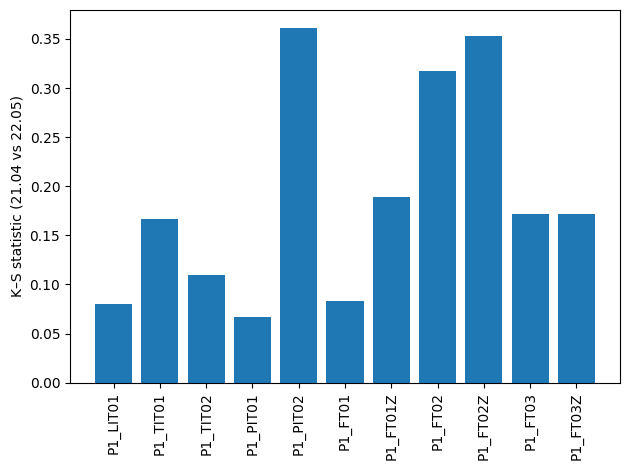

In [258]:
s_df21_22 = compare_datasets(df21_n, df22_n)
plt.bar(range(len(s_df21_22)), list(s_df21_22.values()))
plt.xticks(range(len(s_df21_22)), list(s_df21_22.keys()), rotation=90)
plt.ylabel("K–S statistic (21.04 vs 22.05)")
plt.tight_layout()
plt.show()

In [259]:
def compute_ccdf(values):
    values = sorted(values)
    N = len(values)
    x = []
    y = []
    for i, v in enumerate(values, start=1):
        x.append(v)
        y.append(1 - i / N)
    return x, y

In [260]:
x1, y1 = compute_ccdf(list(s_df21_22.values()))
x2, y2 = compute_ccdf(list(ks_22_23.values()))

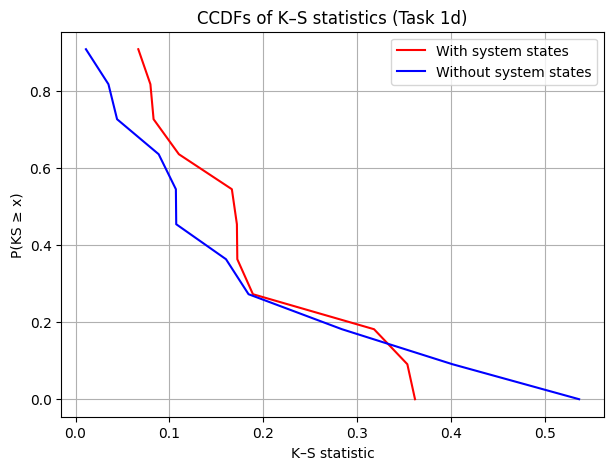

In [261]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(x1, y1, label='With system states', color='red')
plt.plot(x2, y2, label='Without system states', color='blue')
plt.xlabel('K–S statistic')
plt.ylabel('P(KS ≥ x)')
plt.title('CCDFs of K–S statistics (Task 1d)')
plt.legend()
plt.grid(True)
plt.show()